## Import libraries and mount the drive

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from google.colab import drive
drive.mount('/content/drive')

2.2.0-rc3
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('./drive/My Drive/Master_thesis/generation')
from dataset_helpers import load_dataset
from evaluation_metrics import compute_psnr, compute_ssim, compute_mse, compute_mse_tumor, compute_psnr_tumor

## Loading train, validation and test sets

In [0]:
def load_datasets():
    validation = load_dataset(prefix_path + 'brats2015_validation_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=False)
    training = load_dataset(prefix_path + 'brats2015_training_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    testing = load_dataset(prefix_path + 'brats2015_testing_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    return training, validation , testing

In [0]:
prefix_path = './drive/My Drive/Master_thesis/datasets/'
BATCH_SIZE = 32

training, validation, testing = load_datasets()

## Load some useful functions


In [0]:
def resize_with_crop(*args): # possibile arguments: input, gt, prediction and maybe the segmentation

    image0 = tf.image.resize_with_crop_or_pad(args[0], 155, 194)
    image1 = tf.image.resize_with_crop_or_pad(args[1], 155, 194)
    image2 = tf.image.resize_with_crop_or_pad(args[2], 155, 194)
    if len(args) == 4:      # crop also the segmentation, if is given as additional argument
        image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
        return image0, image1, image2, image3
    if len(args) == 6:
        image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        return image0, image1, image2, image3, image4, image5
    if len(args) == 10:      # crop also the segmentation, if is given as additional argument
        image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        image6 = tf.image.resize_with_crop_or_pad(args[6], 155, 194)
        image7 = tf.image.resize_with_crop_or_pad(args[7], 155, 194)
        image8 = tf.image.resize_with_crop_or_pad(args[8], 155, 194)
        image9 = tf.image.resize_with_crop_or_pad(args[9], 155, 194)
        return image0, image1, image2, image3, image4, image5, image6, image7, image8, image9
    return image0, image1, image2

In [0]:
def retrieve_tumor_area(*args):
    segmentation_np = args[0].numpy()
    idx = (segmentation_np==0)     
    # standard case: three arguments (segmentation, gt, prediction)
    image_1 = args[1].numpy()
    image_2 = args[2].numpy()
    image_1[idx] = segmentation_np[idx]
    image_2[idx] = segmentation_np[idx]
    if len(args) == 4:
        image_3 = args[3].numpy()
        image_3[idx] = segmentation_np[idx]
        return image_1, image_2, image_3
    if len(args) == 5:
        image_3 = args[3].numpy()
        image_3[idx] = segmentation_np[idx]
        image_4 = args[4].numpy()
        image_4[idx] = segmentation_np[idx]
        return image_1, image_2, image_3, image_4
    return image_1, image_2

In [0]:
# this method was tested to work with 5 and 32 images. Plotting 2, 3 or 4 types per time.

def plot_images_new(*args, shut_down_from_left=True): 

    if len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]]   # input, gt, prediction, gt masked, pred masked
        title = ['Input', 'GT', 'Prediction', 'GT Tumor', 'Pred Tumor']
        figsize = (14, 7)
    elif len(args) == 3:
        display_list = [args[0], args[1], args[2]]   # input, gt and prediction
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        figsize = (8, 4)
    elif len(args) == 11 and shut_down_from_left == True:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9],args[10]]
        title = ['Input Image', 'Ground Truth','GT tumor', 'Predicted Image', '[0111111]', '[0011111]', '[0001111]', '[0000111]', '[0000011]', '[0000001]','[0000000]']
        figsize = (34, 13)
    elif len(args) == 11 and shut_down_from_left == False:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9], args[10]]
        title = ['Input Image', 'Ground Truth', 'GT tumor', 'Predicted Image', '[1111110]', '[1111100]', '[1111000]', '[1110000]', '[1100000]', '[1000000]','[0000000]']
        figsize = (34, 13)
    elif len(args) == 13 and shut_down_from_left == True:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9], args[10], args[11], args[12]]
        title = ['T1', 'T2', 'T1c', 'Ground Truth','GT tumor', 'Predicted Image',  '[0111111]', '[0011111]', '[0001111]', '[0000111]', '[0000011]', '[0000001]','[0000000]']
        figsize = (42, 16)
    elif len(args) == 13 and shut_down_from_left == False:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9], args[10], args[11], args[12]]
        title = ['T1', 'T2', 'T1c', 'Ground Truth','GT tumor', 'Predicted Image', '[1111110]', '[1111100]', '[1111000]', '[1110000]', '[1100000]', '[1000000]','[0000000]']
        figsize = (42, 16)
    
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):    # batch size is different from 10, but let's show just 10 images.
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        #plt.subplot(1, len(args), n)
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone')
        plt.axis('off')
    plt.show()

# Evaluate GANs

## Evaluate GAN (pix2pix)

In [0]:
def evaluate_GAN(model, dataset, set_type, evaluate_tumor_area=False):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    elif set_type == 'train':
        num_batches = 876
    container_psnr = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim = tf.TensorArray(tf.float32, size=num_batches)
    
    if evaluate_tumor_area:
        container_psnr_tumor = tf.TensorArray(tf.float32, size=num_batches)     
        container_mse_tumor = tf.TensorArray(tf.float32, size=num_batches)
        container_ssim_tumor = tf.TensorArray(tf.float32, size=num_batches)
    
    for idx, (t1, t2, t1c, t2flair, segmentation, patient) in dataset.enumerate():
        inp = t2
        ground_truth = t2flair
        # generate the prediction        
        prediction = model(inp, training=False)
        # crop the images
        inp_cr, ground_truth_cr, prediction_cr, segmentation_cr = resize_with_crop(inp, ground_truth, prediction, segmentation)
        if evaluate_tumor_area:
            prediction_masked_normalized = mean_normalize(prediction_cr)
            ground_truth_masked_normalized = mean_normalize(ground_truth_cr) 
            ground_truth_masked, prediction_masked = retrieve_tumor_area(segmentation_cr, ground_truth_masked_normalized, prediction_masked_normalized)
        if (idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83) and evaluate_tumor_area:
            plot_images_new(inp_cr, ground_truth_cr, prediction_cr, ground_truth_masked, prediction_masked)
        elif idx == 2 or idx == 25 or idx == 45 or idx == 50 or idx == 83:
            plot_images_new(inp_cr, ground_truth_cr, prediction_cr)
        
        # normalize the prediction and the ground_truth
        prediction_normalized_cr = mean_normalize(prediction_cr)
        ground_truth_normalized_cr = mean_normalize(ground_truth_cr)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction_normalized_cr)
        container_psnr = container_psnr.write(idx, psnr)
        mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction_normalized_cr)
        container_mse = container_mse.write(idx, mse)
        mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction_normalized_cr)
        container_ssim = container_ssim.write(idx, ssim)

        #if idx == 0:
        #    print("Metrics")
        #    print()
        #    print(psnr)

        if evaluate_tumor_area:
            # discard black images from pred and gt
            #    plot_images(ground_truth_masked, prediction_masked)
            mean, std, psnr = compute_psnr_tumor(ground_truth_masked, prediction_masked)
            container_psnr_tumor = container_psnr_tumor.write(idx, psnr)
            mean, std, mse = compute_mse_tumor(ground_truth_masked, prediction_masked)
            container_mse_tumor = container_mse_tumor.write(idx, mse)
            mean, std, ssim = compute_ssim(ground_truth_masked, prediction_masked)
            container_ssim_tumor = container_ssim_tumor.write(idx, ssim)

            #if idx == 0:
            #    print("Metrics wrt tumor area")
            #    print()
            #    print(psnr)
        #idx += 1

    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))

    print("PSNR on {} set: {} ± {}".format(set_type, (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("MSE on {} set: {} ± {}".format(set_type, (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("SSIM on {} set: {} ± {}".format(set_type, (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))
    print()

    if evaluate_tumor_area:
        container_psnr_tumor = container_psnr_tumor.stack()
        container_mse_tumor = container_mse_tumor.stack()
        container_ssim_tumor = container_ssim_tumor.stack()
        threshold = 228
        container_psnr_tumor = tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor))
        container_psnr_tumor = container_psnr_tumor[container_psnr_tumor < threshold]

        mean_psnr_tumor = tf.reduce_mean(container_psnr_tumor)
        std_psnr_tumor = tf.math.reduce_std(container_psnr_tumor)
        mean_mse_tumor = tf.reduce_mean(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        std_mse_tumor = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        mean_ssim_tumor = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        std_ssim_tumor = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        print()
        print("PSNR wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_psnr_tumor:.4f}'), (f'{std_psnr_tumor:.4f}')))
        print("MSE wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_mse_tumor:.4f}'), (f'{std_mse_tumor:.4f}')))
        print("SSIM wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_ssim_tumor:.4f}'), (f'{std_ssim_tumor:.4f}')))

        #print()
        #print("Size of the container where there are all the PSNR wrt tumor area")
        #print(container_psnr_tumor.shape)

        #return container_psnr_tumor

## Evaluate GAN (MI-pix2pix)

In [0]:
def evaluate_GAN2(model, dataset, set_type, evaluate_tumor_area=False):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    elif set_type == 'train':
        num_batches = 876
    
    #num_batches = 10
    container_psnr = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim = tf.TensorArray(tf.float32, size=num_batches)
    
    if evaluate_tumor_area:
        container_psnr_tumor = tf.TensorArray(tf.float32, size=num_batches)     
        container_mse_tumor = tf.TensorArray(tf.float32, size=num_batches)
        container_ssim_tumor = tf.TensorArray(tf.float32, size=num_batches)
    
    for idx, (t1, t2, t1c, t2flair, segmentation, patient) in dataset.enumerate():
        # preparing the input to the generator
        ground_truth = t2flair
        # INPUT IMPUTATION
        input_tensor = tf.concat([t1, t2, t1c], 3)

        # BE CAREFUL: 
        # MI-GAN and MI-pix2pix were developed with different input_tensor (so with different informations
        # passing through the channels). 
        # MI-GAN wants an input_tensor [t1, t1c, t2] while MI-pix2pix wants [t1, t2, t1c] as input tensor

        # generate the prediction            
        prediction = model(input_tensor, training=False)
        t1_cr, t2_cr, t1c_cr, t2flair_original_cr, t2flair_generated_cr, segmentation_cr = resize_with_crop(t1, t2, t1c, ground_truth, prediction, segmentation)
        if evaluate_tumor_area:
            prediction_masked_normalized = mean_normalize(t2flair_generated_cr)
            ground_truth_masked_normalized = mean_normalize(t2flair_original_cr) 
            ground_truth_masked, prediction_masked = retrieve_tumor_area(segmentation_cr, ground_truth_masked_normalized, prediction_masked_normalized)
        
        # normalize the prediction and the ground_truth
        prediction_normalized_cr = mean_normalize(t2flair_generated_cr)
        ground_truth_normalized_cr = mean_normalize(t2flair_original_cr)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction_normalized_cr)
        container_psnr = container_psnr.write(idx, psnr)
        mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction_normalized_cr)
        container_mse = container_mse.write(idx, mse)
        mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction_normalized_cr)
        container_ssim = container_ssim.write(idx, ssim)

        if evaluate_tumor_area:
            mean, std, psnr = compute_psnr_tumor(ground_truth_masked, prediction_masked)
            container_psnr_tumor = container_psnr_tumor.write(idx, psnr)
            mean, std, mse = compute_mse_tumor(ground_truth_masked, prediction_masked)
            container_mse_tumor = container_mse_tumor.write(idx, mse)
            mean, std, ssim = compute_ssim(ground_truth_masked, prediction_masked)
            container_ssim_tumor = container_ssim_tumor.write(idx, ssim)

    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))

    print("PSNR on {} set: {} ± {}".format(set_type, (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("MSE on {} set: {} ± {}".format(set_type, (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("SSIM on {} set: {} ± {}".format(set_type, (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))

    if evaluate_tumor_area:
        container_psnr_tumor = container_psnr_tumor.stack()
        container_mse_tumor = container_mse_tumor.stack()
        container_ssim_tumor = container_ssim_tumor.stack()
        
        threshold = 228
        container_psnr_tumor = tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor))
        container_psnr_tumor = container_psnr_tumor[container_psnr_tumor < threshold]

        mean_psnr_tumor = tf.reduce_mean(container_psnr_tumor)
        std_psnr_tumor = tf.math.reduce_std(container_psnr_tumor)
        mean_mse_tumor = tf.reduce_mean(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        std_mse_tumor = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        mean_ssim_tumor = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        std_ssim_tumor = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        print()
        print("PSNR wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_psnr_tumor:.4f}'), (f'{std_psnr_tumor:.4f}')))
        print("MSE wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_mse_tumor:.4f}'), (f'{std_mse_tumor:.4f}')))
        print("SSIM wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_ssim_tumor:.4f}'), (f'{std_ssim_tumor:.4f}')))
    

## Evaluate GAN (MI-GAN)

In [0]:
def evaluate_GAN3(model, dataset, set_type, evaluate_tumor_area=False):
    num_batches = 0                 # CAREFUL when batch_size is modified!!!
    if set_type == 'test':
        num_batches = 112           # in the test set, with batch 32, there are 112 elements.
    elif set_type == 'validation':
        num_batches = 108
    elif set_type == 'train':
        num_batches = 876
    
    #num_batches = 10
    container_psnr = tf.TensorArray(tf.float32, size=num_batches)     
    container_mse = tf.TensorArray(tf.float32, size=num_batches)
    container_ssim = tf.TensorArray(tf.float32, size=num_batches)
    
    if evaluate_tumor_area:
        container_psnr_tumor = tf.TensorArray(tf.float32, size=num_batches)     
        container_mse_tumor = tf.TensorArray(tf.float32, size=num_batches)
        container_ssim_tumor = tf.TensorArray(tf.float32, size=num_batches)

    for idx, (t1, t2, t1c, t2flair, segmentation, patient) in dataset.enumerate():
        # preparing the input to the generator
        ground_truth = tflair
        # INPUT IMPUTATION
        #gt_imputed = tf.zeros((32, 256, 256, 1), dtype=tf.dtypes.float32)
        input_tensor = tf.concat([t1, t1c, t2], 3)

        prediction = model(input_tensor, training=False)

        # crop the images
        t1_cr, t1c_cr, t2_cr, t2flair_original_cr, t2flair_generated_cr, segmentation_cr = resize_with_crop(t1, t1c, t2, ground_truth, prediction, segmentation)
        if evaluate_tumor_area:
            prediction_masked_normalized = mean_normalize(t2flair_generated_cr)
            ground_truth_masked_normalized = mean_normalize(t2flair_original_cr) 
            ground_truth_masked, prediction_masked = retrieve_tumor_area(segmentation_cr, ground_truth_masked_normalized, prediction_masked_normalized)
        
        # normalize the prediction and the ground_truth
        prediction_normalized_cr = mean_normalize(t2flair_generated_cr)
        ground_truth_normalized_cr = mean_normalize(t2flair_original_cr)

        # compute the metrics of similarity
        mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction_normalized_cr)
        container_psnr = container_psnr.write(idx, psnr)
        mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction_normalized_cr)
        container_mse = container_mse.write(idx, mse)
        mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction_normalized_cr)
        container_ssim = container_ssim.write(idx, ssim)

        if evaluate_tumor_area:
            mean, std, psnr = compute_psnr_tumor(ground_truth_masked, prediction_masked)
            container_psnr_tumor = container_psnr_tumor.write(idx, psnr)
            mean, std, mse = compute_mse_tumor(ground_truth_masked, prediction_masked)
            container_mse_tumor = container_mse_tumor.write(idx, mse)
            mean, std, ssim = compute_ssim(ground_truth_masked, prediction_masked)
            container_ssim_tumor = container_ssim_tumor.write(idx, ssim)

    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))

    print("PSNR on {} set: {} ± {}".format(set_type, (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("MSE on {} set: {} ± {}".format(set_type, (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("SSIM on {} set: {} ± {}".format(set_type, (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))

    if evaluate_tumor_area:
        container_psnr_tumor = container_psnr_tumor.stack()
        container_mse_tumor = container_mse_tumor.stack()
        container_ssim_tumor = container_ssim_tumor.stack()
        
        threshold = 228
        container_psnr_tumor = tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor))
        container_psnr_tumor = container_psnr_tumor[container_psnr_tumor < threshold]

        mean_psnr_tumor = tf.reduce_mean(container_psnr_tumor)
        std_psnr_tumor = tf.math.reduce_std(container_psnr_tumor)
        mean_mse_tumor = tf.reduce_mean(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        std_mse_tumor = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        mean_ssim_tumor = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        std_ssim_tumor = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        print()
        print("PSNR wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_psnr_tumor:.4f}'), (f'{std_psnr_tumor:.4f}')))
        print("MSE wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_mse_tumor:.4f}'), (f'{std_mse_tumor:.4f}')))
        print("SSIM wrt tumor area on {} set: {} ± {}".format(set_type, (f'{mean_ssim_tumor:.4f}'), (f'{std_ssim_tumor:.4f}')))
    

# Mean normalization

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5c591a0eeba163a12f69f937adbae5886d6273db)

In the paper they say: "Each patient scan is normalized by dividing each sequence by its mean intensity value. "
But the formula is taken from a lecture from Andrew Ng, where he defines the Mean normalization as in the formula above. (resource: https://www.youtube.com/watch?v=e1nTgoDI_m8)

See also: https://stats.stackexchange.com/questions/138046/normalizations-dividing-by-mean

In [0]:
def mean_rescale(x, xmin, xmax):
    mean = tf.reduce_mean(x)
    return ((x-mean)/(xmax-xmin)) 

In [0]:
@tf.function
def mean_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = mean_rescale(image[i], min_value, max_value)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized
    

# Discard black images from batch (put values to 'nan')

This normalization is just to test the metrics and see if there is a big difference in normalizing the prediction and the gt.
This method is used to normalize (and so put to 'nan') only the black images, while the other images of the batch are kept with the original values. This allows me to discard the black images in the computation of the metrics.

In [0]:
def black_images_to_nan(image): 
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])

        # if the max = min most likely it's a black image (or an image without any important information)
        if tf.math.equal(max_value, min_value):        
            x = mean_rescale(image[i], min_value, max_value)
            image_normalized = image_normalized.write(i, x)
        else:
            image_normalized = image_normalized.write(i, image[i])
    image_normalized = image_normalized.stack()
    return image_normalized

# Generate predictions

In [0]:
def generate_predictions(inp):
    predictions = []
    for generator in generators:
        prediction = generator(inp, training=False)
        predictions.append(prediction)
    return predictions

In [0]:
def print_qualitative_results(dataset, model, focus_on_tumor):

    idx = 0
    indexes = [2,10,11,13,18,22,23,26,29,25,37,38,41,42,45,46]
    for t1, t2, t1c, tflair, segmentation, patient in testing.take(46):
        if idx in indexes:
            # preparing the input to the generator
            ground_truth = tflair
            shut_down_from_left = True

            if model == 0:      # pix2pix
                inp = t2
            elif model == 1:    # MI-pix2pix
                inp = tf.concat([t1, t2, t1c], 3)
            elif model == 2:    # MI-GAN (modified version)
                inp = tf.concat([t1, t1c, t2], 3)

            (prediction1, prediction2, prediction3, prediction4, prediction5, 
            prediction6, prediction7, prediction8, prediction9, prediction10, 
            prediction11, prediction12, prediction13, prediction14) = generate_predictions(inp)

            # crop the images
            t1_cr, t2_cr, t1c_cr, ground_truth_cr = resize_with_crop(t1, t2, t1c, tflair)
            segmentation_cr, prediction1_cr, prediction2_cr = resize_with_crop(segmentation, prediction1, prediction2)
            prediction3_cr, prediction4_cr, prediction5_cr, prediction6_cr = resize_with_crop(prediction3, prediction4, prediction5, prediction6)
            prediction7_cr, prediction8_cr, prediction9_cr, prediction10_cr = resize_with_crop(prediction7, prediction8, prediction9, prediction10)
            prediction11_cr, prediction12_cr, prediction13_cr, prediction14_cr = resize_with_crop(prediction11, prediction12, prediction13, prediction14)
            
            gt_masked, temp1 = retrieve_tumor_area(segmentation_cr, ground_truth_cr, prediction1_cr)
            if focus_on_tumor: 
                gt_masked, prediction1_cr, prediction2_cr, prediction3_cr = retrieve_tumor_area(segmentation_cr, ground_truth_cr, prediction1_cr, prediction2_cr, prediction3_cr)
                prediction4_cr, prediction5_cr, prediction6_cr, prediction7_cr = retrieve_tumor_area(segmentation_cr, prediction4_cr, prediction5_cr, prediction6_cr, prediction7_cr)
                prediction8_cr, prediction9_cr, prediction10_cr, prediction11_cr = retrieve_tumor_area(segmentation_cr, prediction8_cr, prediction9_cr, prediction10_cr, prediction11_cr)
                prediction12_cr, prediction13_cr, prediction14_cr = retrieve_tumor_area(segmentation_cr, prediction12_cr, prediction13_cr, prediction14_cr)
                
            if model == 0:
                plot_images_new(t2_cr, ground_truth_cr, gt_masked, prediction1_cr, prediction2_cr, prediction3_cr, prediction4_cr, prediction5_cr, prediction6_cr, prediction7_cr, prediction8_cr)
                plot_images_new(t2_cr, ground_truth_cr, gt_masked, prediction1_cr, prediction9_cr, prediction10_cr, prediction11_cr, prediction12_cr, prediction13_cr, prediction14_cr, prediction8_cr, shut_down_from_left=False)
                print()
                print()
            elif model == 1 or model == 2:
                plot_images_new(t1_cr, t2_cr, t1c_cr, ground_truth_cr, gt_masked, prediction1_cr, prediction2_cr, prediction3_cr, prediction4_cr, prediction5_cr, prediction6_cr, prediction7_cr, prediction8_cr)
                plot_images_new(t1_cr, t2_cr, t1c_cr, ground_truth_cr, gt_masked, prediction1_cr, prediction9_cr, prediction10_cr, prediction11_cr, prediction12_cr, prediction13_cr, prediction14_cr, prediction8_cr, shut_down_from_left=False)
                print()
                print()
                
        idx += 1

# Defining models and optimizers

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1

In [0]:
LAMBDA = 100

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def downsample2(filters, size, instance, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))

    if apply_norm:
        if instance:
            result.add(tfa.layers.InstanceNormalization())
        else:
            result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    result.add(tf.keras.layers.Dropout(0.5))

    return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
def upsample2(filters, size, instance, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    if instance:
        result.add(tfa.layers.InstanceNormalization())
    else:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    return result

In [0]:
def discriminator_block(filters, size, apply_instancenorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_instancenorm:
    result.add(tf.keras.layers.BatchNormalization())
    #result.add(tfa.layers.InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

## GENERATOR pix2pix & MI-pix2pix

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator(alpha, single_input=True):
    if single_input:
        inputs = tf.keras.layers.Input(shape=[256,256,1], batch_size=BATCH_SIZE)
    elif single_input==False:
        inputs = tf.keras.layers.Input(shape=[256,256,3], batch_size=BATCH_SIZE)

    down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
    ]
    up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                            kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 1)
    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    idx = 0
    for up, skip in zip(up_stack, skips):
        skip = skip * alpha[idx]
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        idx += 1

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Result of the test done about the downsample/upsample layer:
- If an totally black image/batch of images is multiplied by 0 and then fed into a downsample/upsample layer, the output image/batch of images will be still totally black (all values set to 0).


## GENERATOR MI-GAN

In [0]:
def Generator2(alpha):

    inputs = tf.keras.layers.Input(shape=[256,256,3], batch_size=BATCH_SIZE)
    OUTPUT_CHANNELS = 1
    instance = False

    down_stack = [
    downsample2(4, 4, instance, apply_norm=False),
    downsample2(64, 4, instance),
    downsample2(128, 4, instance),
    downsample2(256, 4, instance),
    downsample2(512, 4, instance),
    downsample2(512, 4, instance),
    downsample2(512, 4, instance),
    downsample2(512, 4, instance),
    ]
    up_stack = [
    upsample2(512, 4, instance, apply_dropout=True),
    upsample2(1024, 4, instance, apply_dropout=True),
    upsample2(1024, 4, instance, apply_dropout=True),
    upsample2(1024, 4, instance),
    upsample2(1024, 4, instance), 
    upsample2(512, 4, instance),
    upsample2(256, 4, instance),
    upsample2(128, 4, instance),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                            kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 2)
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    idx = 0
    for up, skip in zip(up_stack, skips):
        skip = skip * alpha[idx]
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        idx += 1

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## DISCRIMINATOR pix2pix & MI-pix2pix

In [0]:
def Discriminator(single_input=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    if single_input:
        inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image', batch_size=BATCH_SIZE)
    elif single_input==False:
        inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image', batch_size=BATCH_SIZE)
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) #(bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

## DISCRIMINATOR MI-GAN

In [0]:
def Discriminator2():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image', batch_size=BATCH_SIZE)
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)
    OUTPUT_CHANNELS = 1
    
    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, 4*2)

    down1 = discriminator_block(8, 4, False)(x) # (bs, 128, 128, 64)
    down2 = discriminator_block(64, 4)(down1) # (bs, 64, 64, 128)
    down3 = discriminator_block(128, 4)(down2) # (bs, 32, 32, 256)
    down4 = discriminator_block(256, 4)(down3) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 34, 34, 256)

    last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 4, strides=1, kernel_initializer=initializer)(zero_pad1) # (bs, 15, 15, 1)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Print quantitative results (metrics)

## pix2pix

Optimizers and models defined but not initialized? True
Optimizers and models defined but not initialized? True



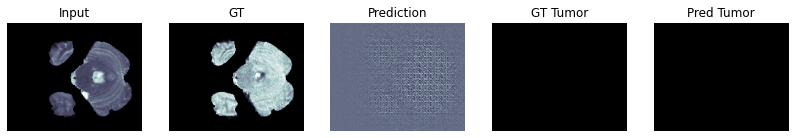

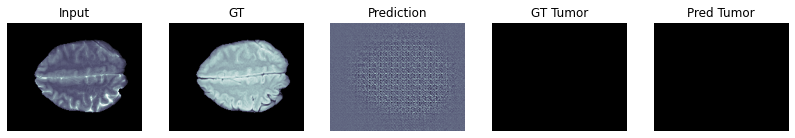

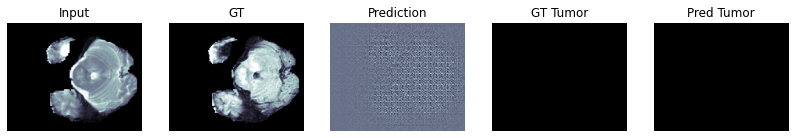

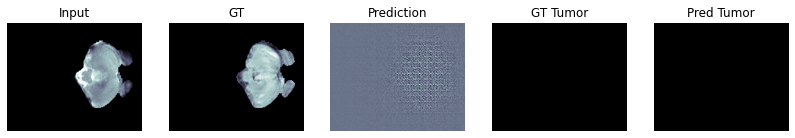

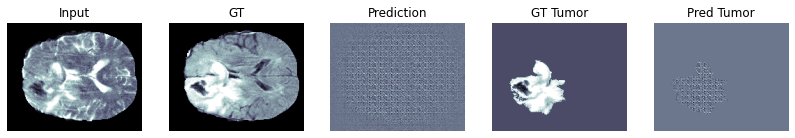

PSNR on test set: 10.0755 ± 2.7578
MSE on test set: 0.1116 ± 0.0424
SSIM on test set: 0.0231 ± 0.0751


PSNR wrt tumor area on test set: 4.2964 ± 1.2325
MSE wrt tumor area on test set: 0.3871 ± 0.1136
SSIM wrt tumor area on test set: 0.9429 ± 0.0697


In [32]:

np.random.seed(123)
tf.random.set_seed(123)

alpha = [1, 1, 1, 1, 1, 0, 0]

generator = Generator(alpha, single_input=True)
discriminator = Discriminator(single_input=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

evaluate_GAN(generator, testing, 'test', evaluate_tumor_area=True)


## MI-pix2pix

In [0]:

np.random.seed(123)
tf.random.set_seed(123)

alpha = [0,0,0,0,0,0,1]

single_input = False
generator = Generator(alpha, single_input)
discriminator = Discriminator(single_input)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

evaluate_GAN2(generator, testing, 'test', evaluate_tumor_area=True)


## MI-GAN

In [0]:
"""
#alphas = [[1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0]]
alphas = [[1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 0]]


for alpha in alphas:
    generator = Generator2(alpha)
    discriminator = Discriminator2()
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

    checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"

    ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                    discriminator_optimizer=discriminator_optimizer,
                                    generator=generator,
                                    discriminator=discriminator)

    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print ('Latest checkpoint restored!!')
    print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
    print()
    print(alpha)
    evaluate_GAN3(generator, testing, 'test', evaluate_tumor_area=True)"""

# Model loading from checkpints

## Initialize pix2pix models

In [0]:
generators = []

alpha = [1, 1, 1, 1, 1, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator1 = generator
generators.append(generator1)

alpha = [0, 1, 1, 1, 1, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator2 = generator
generators.append(generator2)

alpha = [0, 0, 1, 1, 1, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator3 = generator
generators.append(generator3)

alpha = [0, 0, 0, 1, 1, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator4 = generator
generators.append(generator4)

alpha = [0, 0, 0, 0, 1, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator5 = generator
generators.append(generator5)

alpha = [0, 0, 0, 0, 0, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator6 = generator
generators.append(generator6)

alpha = [0, 0, 0, 0, 0, 0, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator7 = generator
generators.append(generator7)

alpha = [0, 0, 0, 0, 0, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator8 = generator
generators.append(generator8)

alpha = [1, 1, 1, 1, 1, 1, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator9 = generator
generators.append(generator9)

alpha = [1, 1, 1, 1, 1, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator10 = generator
generators.append(generator10)


alpha = [1, 1, 1, 1, 0, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator11 = generator
generators.append(generator11)


alpha = [1, 1, 1, 0, 0, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator12 = generator
generators.append(generator12)

alpha = [1, 1, 0, 0, 0, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator13 = generator
generators.append(generator13)

alpha = [1, 0, 0, 0, 0, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator14 = generator
generators.append(generator14)

## Initialize MI-pix2pix models



In [0]:
generators = []

alpha = [1, 1, 1, 1, 1, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator1 = generator
generators.append(generator1)

alpha = [0, 1, 1, 1, 1, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator2 = generator
generators.append(generator2)

alpha = [0, 0, 1, 1, 1, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator3 = generator
generators.append(generator3)

alpha = [0, 0, 0, 1, 1, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator4 = generator
generators.append(generator4)

alpha = [0, 0, 0, 0, 1, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator5 = generator
generators.append(generator5)

alpha = [0, 0, 0, 0, 0, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator6 = generator
generators.append(generator6)

alpha = [0, 0, 0, 0, 0, 0, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator7 = generator
generators.append(generator7)


alpha = [0, 0, 0, 0, 0, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator8 = generator
generators.append(generator8)

alpha = [1, 1, 1, 1, 1, 1, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator9 = generator
generators.append(generator9)

alpha = [1, 1, 1, 1, 1, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator10 = generator
generators.append(generator10)


alpha = [1, 1, 1, 1, 0, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator11 = generator
generators.append(generator11)


alpha = [1, 1, 1, 0, 0, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator12 = generator
generators.append(generator12)


alpha = [1, 1, 0, 0, 0, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator13 = generator
generators.append(generator13)


alpha = [1, 0, 0, 0, 0, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()


generator14 = generator
generators.append(generator14)

## Initialize MI-GAN models

In [0]:
generators = []

alpha = [1, 1, 1, 1, 1, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator1 = generator
generators.append(generator1)

alpha = [0, 1, 1, 1, 1, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator2 = generator
generators.append(generator2)
alpha = [0, 0, 1, 1, 1, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator3 = generator
generators.append(generator3)

alpha = [0, 0, 0, 1, 1, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator4 = generator
generators.append(generator4)

alpha = [0, 0, 0, 0, 1, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator5 = generator
generators.append(generator5)

alpha = [0, 0, 0, 0, 0, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator6 = generator
generators.append(generator6)

alpha = [0, 0, 0, 0, 0, 0, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator7 = generator
generators.append(generator7)


alpha = [0, 0, 0, 0, 0, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator8 = generator
generators.append(generator8)

alpha = [1, 1, 1, 1, 1, 1, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator9 = generator
generators.append(generator9)

alpha = [1, 1, 1, 1, 1, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator10 = generator
generators.append(generator10)


alpha = [1, 1, 1, 1, 0, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator11 = generator
generators.append(generator11)


alpha = [1, 1, 1, 0, 0, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator12 = generator
generators.append(generator12)


alpha = [1, 1, 0, 0, 0, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator13 = generator
generators.append(generator13)

alpha = [1, 0, 0, 0, 0, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator14 = generator
generators.append(generator14)

# Print qualitative results (images) - WHOLE IMAGES

## Skip connections activation (pix2pix)

1st row: Skip connections disabled from left (inner one) to right (outer one)

2st row: Skip connections disabled from right (outer one) to left (inner one)

In [0]:
model = 0
print_qualitative_results(testing, model, focus_on_tumor = False)

## Skip connections activation (MI-pix2pix)

1st row: Skip connections disabled from left (inner one) to right (outer one)

2st row: Skip connections disabled from right (outer one) to left (inner one)

In [0]:
model = 1
print_qualitative_results(testing, model, focus_on_tumor = False)

## Skip connections activation (MI-GAN)

1st row: Skip connections disabled from left (inner one) to right (outer one)

2st row: Skip connections disabled from right (outer one) to left (inner one)

In [0]:
model = 2
print_qualitative_results(testing, model, focus_on_tumor = False)

# Print qualitative results (images) - TUMOR AREA

## Skip connections (pix2pix)

1st row: Skip connections disabled from left (inner one) to right (outer one)

2st row: Skip connections disabled from right (outer one) to left (inner one)

In [0]:
# pix2pix = 0
# MI-pix2pix = 1
# MI-GAN = 2

model = 0
print_qualitative_results(testing, model, focus_on_tumor = True)

## Skip connections (MI-pix2pix)

1st row: Skip connections disabled from left (inner one) to right (outer one)

2st row: Skip connections disabled from right (outer one) to left (inner one)

In [0]:
model = 1
print_qualitative_results(testing, model, focus_on_tumor = True)

## Skip connections (MI-GAN)

1st row: Skip connections disabled from left (inner one) to right (outer one)

2st row: Skip connections disabled from right (outer one) to left (inner one)

In [0]:
model = 2
print_qualitative_results(testing, model, focus_on_tumor = True)

# Snippet used to print images in the thesis

In [0]:
def plot_results(*args, title): 
    
    if len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]] 
        # r'pix2pix$(T_{2 \rightarrow 1})$'
        figsize = (14, 6)
    
  
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):    # batch size is different from 10, but let's show just 10 images.
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        plt.subplot(1, len(args), n).title.set_size(16)
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone')
        plt.axis('off')
    plt.subplots_adjust(left=0, bottom=None, right=0.75, top=None, wspace=0.0, hspace=None)
    plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


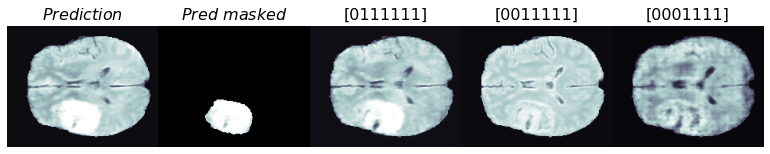

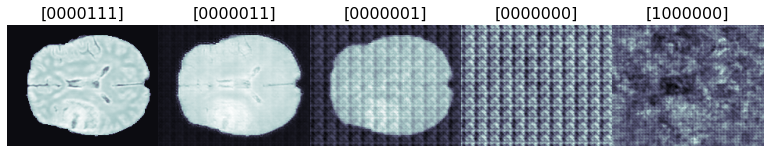

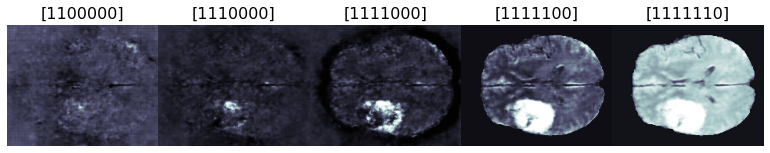

In [0]:
title1 = [r'$Prediction$', r'$Pred\ masked$', '[0111111]', '[0011111]', '[0001111]']
title2 = ['[0000111]', '[0000011]', '[0000001]','[0000000]', '[1000000]']
title3 = ['[1100000]', '[1110000]', '[1111000]','[1111100]','[1111110]']

idx = 0
indexes = [2,10,11,13,18,22,23,26,29,25,37,38,41,42,45,46]
for t1, t2, t1c, tflair, segmentation, patient in testing.take(77):
    if idx == 10: # 2 # 10 # 26
        ground_truth = tflair
        inp = tf.concat([t1, t1c, t2], 3)

        (prediction1, prediction2, prediction3, prediction4, prediction5, 
        prediction6, prediction7, prediction8, prediction9, prediction10, 
        prediction11, prediction12, prediction13, prediction14) = generate_predictions(inp, True)

        # crop the images
        t1_cr, t2_cr, t1c_cr, ground_truth_cr = resize_with_crop(t1, t2, t1c, tflair)
        segmentation_cr, prediction1_cr, prediction2_cr = resize_with_crop(segmentation, prediction1, prediction2)
        prediction3_cr, prediction4_cr, prediction5_cr, prediction6_cr = resize_with_crop(prediction3, prediction4, prediction5, prediction6)
        prediction7_cr, prediction8_cr, prediction9_cr, prediction10_cr = resize_with_crop(prediction7, prediction8, prediction9, prediction10)
        prediction11_cr, prediction12_cr, prediction13_cr, prediction14_cr = resize_with_crop(prediction11, prediction12, prediction13, prediction14)
        
        pred1_masked, pred2_masked = retrieve_tumor_area(segmentation_cr,prediction1_cr, prediction2_cr)

        plot_results(prediction1_cr, pred1_masked, prediction2_cr, prediction3_cr, prediction4_cr, title=title1)
        plot_results(prediction5_cr, prediction6_cr, prediction7_cr, prediction8_cr, prediction14_cr, title=title2)
        plot_results(prediction13_cr, prediction12_cr, prediction11_cr, prediction10_cr, prediction9_cr, title=title3)
    
        print()
        print()
            
    idx += 1